In [1]:
from copy import deepcopy
import numpy as np
import pandas as pd
import pickle
from Bio import Phylo
import argparse
import warnings

In [2]:
tree = Phylo.read(f'/data3/wangkun/mtsim_res/res_1113/linear_const/29625/linear_tree_gt_29625.nwk', format='newick')
tree_origin = pd.read_csv(f'/data3/wangkun/mtsim_res/res_1113/linear_const/29625/tree_origin_linear_29625.csv')
mt = pickle.load(open(f'/data3/wangkun/mtsim_res/res_1113/linear_const/29625/mt_allmuts_const_0.1_29625.pkl', 'rb'))

In [48]:
def cell_division_with_mt1(mt_muts, mt_copynumber=2):
    new_mts = []
    if mt_copynumber == 2:
        new_mts = mt_muts*2
    elif mt_copynumber > 2:
        new_mts = mt_muts*2
        n_mts = len(mt_muts)
        addi = np.random.choice(range(n_mts), int(n_mts*(mt_copynumber-2)), replace=False)
        new_mts = new_mts + list(np.array(mt_muts)[addi])
    else:
        new_mts = mt_muts
        n_mts = len(mt_muts)
        addi = np.random.choice(range(n_mts), int(n_mts*(mt_copynumber-2)), replace=False)
        new_mts = new_mts + list(np.array(mt_muts)[addi])
        
    division = np.random.binomial(1, 0.5, len(new_mts)).astype(bool)
    if np.sum(division) < 100:
        division = ~division
    cell1 = np.array(new_mts)[division]
    cell2 = np.array(new_mts)[~division]
    return list(cell1), list(cell2)

def ncell_division_with_mt1(mt_muts, mt_copynumber=2):
    res = []
    for cell in mt_muts:
        res1, res2 = cell_division_with_mt1(cell, mt_copynumber=mt_copynumber)
        res.append(res1)
        res.append(res2)
    n_cells = len(res)
    res_new = []
    for i in np.where(np.random.binomial(1, 0.5, n_cells))[0]:
        res_new.append(res[i])
    return res_new

In [202]:
mt50 = pickle.load(open(f'/data3/wangkun/mtsim_res/res_1113/linear_const/29625/mt_allmuts_const_0.1_29625_50.pkl', 'rb'))

In [343]:
def tumor_sim(mts):
    tumor_init = np.random.choice(list(mts.keys()))
    tumor_cells = [mts[tumor_init]]
    for _ in range(10):
        tumor_cells_new = []
        for c in tumor_cells:
            tumor_cells_new = tumor_cells_new + [*cell_division_with_mt1(mts[tumor_init])]
        tumor_cells = deepcopy(tumor_cells_new)
    for _ in range(10):
        tumor_cells = ncell_division_with_mt1(tumor_cells_new)
    for cnt, i in enumerate(tumor_cells):
        mts[f'{tumor_init}_t{cnt}'] = i
    return tumor_init, mts

def generate_tumor_tsne(tsne, tumor_init, tumor_size=1000, d2i_scale=15, size_scale=5):
    cent = np.array([*tsne.loc[tumor_init]])
    rad = np.array(tsne.max()-tsne.min())/6
    neigh = tsne[(tsne.iloc[:,0]>cent[0]-rad[0])&(tsne.iloc[:,0]<cent[0]+rad[0])&(tsne.iloc[:,1]>cent[1]-rad[1])&(tsne.iloc[:,1]<cent[1]+rad[1])]
    neigh_cent = neigh.mean()
    x1, y1 = cent
    x2, y2 = neigh_cent
    l = np.sqrt(((np.array(tsne.max()-tsne.min())/d2i_scale)**2).sum())
    x = (-np.sqrt(l**2 * (x1 - x2)**2 * (x1**2 - 2*x1*x2 + x2**2 + (y1 - y2)**2)) - 2*x1**2*x2 + x1**3 + x1*(x2**2 + (y1 - y2)**2))/(x1**2 - 2*x1*x2 + x2**2 + (y1 - y2)**2)
    y = (x1**3*y1 - 3*x1**2*x2*y1 - x2**3*y1 + x1*y1*(3*x2**2 + (y1 - y2)**2) - x2*y1*(y1 - y2)**2 + np.sqrt(l**2 * (x1 - x2)**2 * (x1**2 - 2*x1*x2 + x2**2 + (y1 - y2)**2)) * (-y1 + y2))/((x1 - x2) * (x1**2 - 2*x1*x2 + x2**2 + (y1 - y2)**2))
    tumor_tsne = np.random.normal(loc=[x,y], scale=[l/size_scale,l/size_scale], size=(tumor_size,2))
    return tumor_tsne

In [349]:
tumor_mts.keys()

dict_keys(['<20_5054>', '<18_5355>', '<16_3908>', '<15_2682>', '<15_2460>', '<16_4259>', '<15_2694>', '<13_1696>', '<20_2564>', '<19_4362>', '<14_2082>', '<17_4979>', '<15_3561>', '<16_3963>', '<25_1830>', '<25_2187>', '<23_1748>', '<26_1249>', '<19_5278>', '<21_5502>', '<27_841>', '<26_1093>', '<23_3598>', '<22_4699>', '<22_2147>', '<25_2053>', '<20_4666>', '<20_5088>', '<19_4112>', '<20_5575>', '<24_3027>', '<22_3016>', '<24_2658>', '<27_467>', '<28_356>', '<24_252>', '<24_2936>', '<24_2937>', '<22_2821>', '<23_216>', '<22_1528>', '<21_773>', '<22_4369>', '<22_4171>', '<19_1085>', '<21_5162>', '<20_2682>', '<20_3944>', '<23_3968>', '<23_3969>', '<22_3773>', '<23_3661>', '<21_3879>', '<20_3865>', '<17_1537>', '<21_5065>', '<19_2458>', '<25_1702>', '<23_2366>', '<22_4801>', '<22_3344>', '<22_4421>', '<24_2226>', '<23_2452>', '<21_1457>', '<21_3397>', '<23_3595>', '<20_4897>', '<17_3335>', '<17_2110>', '<17_4417>', '<20_4335>', '<27_122>', '<29_223>', '<28_171>', '<27_234>', '<27_439>',

In [341]:
tumor_tsne = generate_tumor_tsne(tsne, '<12_1350>')

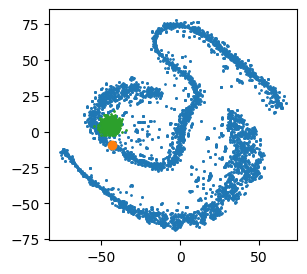

In [342]:
fig, ax = plt.subplots(figsize=(3.2,3))
ax.scatter(tsne.iloc[:,0], tsne.iloc[:,1], s=1)
ax.scatter(*tsne.loc['<12_1350>'])
neigh = tsne[(tsne.iloc[:,0]>cent[0]-rad[0])&(tsne.iloc[:,0]<cent[0]+rad[0])&(tsne.iloc[:,1]>cent[1]-rad[1])&(tsne.iloc[:,1]<cent[1]+rad[1])]
# ax.scatter(neigh.iloc[:,0], neigh.iloc[:,1], s=1)
# ax.scatter(*neigh_cent)
ax.scatter(tumor_tsne[:,0], tumor_tsne[:,1], s=1)

In [229]:
tsne

,0,1
<20_5054>,-7.105758,75.344980
<18_5355>,-26.107395,29.332659
<16_3908>,31.337448,-33.907790
<15_2682>,23.556690,-40.942110
<15_2460>,32.685160,-41.066654
...,...,...
<17_4252>,18.535036,-31.581514
<18_4814>,-18.968430,-18.079082
<12_1350>,-43.037495,-9.065542
<10_637>,-71.305790,-16.540236


In [ ]:
def tsne_regenerate(tsne, mts_rs, distrub_scale=50):
    n_cells = []
    for i in mts_rs:
        n_cells.append(len(mts_rs[i]))
    living_cells = np.array(list(mts_rs.keys()))[np.array(n_cells)!=0]
    new_tsne = pd.DataFrame(columns=[0,1])
    disturb = np.array(tsne.max()-tsne.min())/distrub_scale
    for cell in living_cells:
        tsne_loc = tsne.loc[cell].to_numpy()
        for ind, i in enumerate(mts_rs[cell]):
            new_tsne.loc[f'{cell}_{ind}'] = tsne_loc + np.random.normal(loc=tsne_loc, scale=disturb)
    return new_tsne

In [52]:
# for imb in [0.1, 1, 5]:
diff_model = 'const'    
new_mts_50 = dict()
new_mts_100 = dict()
new_mts_300 = dict()
new_mts_800 = dict()
if diff_model == 'const':
    for cell in tree.get_terminals():
        new_mts_50[cell.name] = [mt[cell.name]]
        for _ in range(50):
            new_mts_50[cell.name] = ncell_division_with_mt1(new_mts_50[cell.name])
        new_mts_100[cell.name] = new_mts_50[cell.name]

        for _ in range(50):
            new_mts_100[cell.name] = ncell_division_with_mt1(new_mts_100[cell.name])
        new_mts_300[cell.name] = new_mts_100[cell.name]

        for _ in range(200):
            new_mts_300[cell.name] = ncell_division_with_mt1(new_mts_300[cell.name])
        new_mts_800[cell.name] = new_mts_300[cell.name]

        for _ in range(500):
            new_mts_800[cell.name] = ncell_division_with_mt1(new_mts_800[cell.name])
else:
    for cell in tree.get_terminals():
        new_mts_50[cell.name] = [mt[cell.name]]
        for _ in range(12):
            new_mts_50[cell.name] = ncell_division_with_mt1(new_mts_50[cell.name], 2.2)
        for _ in range(38):
            new_mts_50[cell.name] = ncell_division_with_mt1(new_mts_50[cell.name])
        new_mts_100[cell.name] = new_mts_50[cell.name]
        for _ in range(50):
            new_mts_100[cell.name] = ncell_division_with_mt1(new_mts_100[cell.name])
        new_mts_300[cell.name] = new_mts_100[cell.name]
        for _ in range(200):
            new_mts_300[cell.name] = ncell_division_with_mt1(new_mts_300[cell.name])
        new_mts_800[cell.name] = new_mts_300[cell.name]
        for _ in range(500):
            new_mts_800[cell.name] = ncell_division_with_mt1(new_mts_800[cell.name])


In [117]:
n_cells = []
for i in new_mts_800:
    n_cells.append(len(new_mts_800[i]))
np.array(list(new_mts_800.keys()))[np.array(n_cells)!=0]

array(['<20_3500>', '<28_406>', '<22_2126>', '<21_373>', '<15_3016>',
       '<14_2494>', '<22_4975>', '<19_1183>', '<27_988>', '<30_66>',
       '<22_4450>', '<24_2312>', '<25_1368>', '<24_1509>', '<21_3482>',
       '<21_3807>', '<18_5214>', '<22_4028>', '<20_5344>', '<21_5402>',
       '<21_3432>'], dtype='<U9')

In [119]:
cell_num = dict(zip(np.array(list(new_mts_800.keys()))[np.array(n_cells)!=0], [len(new_mts_800[i]) for i in np.array(list(new_mts_800.keys()))[np.array(n_cells)!=0]]))

In [121]:
state_num = {0:0,1:0,2:0,3:0,4:0}
# for i in tree_origin.loc[np.array(list(new_mts_50.keys()))[np.array(n_cells)!=0]]['state']:

for i in cell_num:
    state_num[tree_origin.loc[i]['state']] += cell_num[i]
    

In [122]:
state_num

{0: 571, 1: 394, 2: 1248, 3: 2204, 4: 736}

In [123]:
Counter(tree_origin.loc[np.array(list(new_mts_800.keys()))[np.array(n_cells)!=0]]['state'])

Counter({4: 5, 3: 5, 0: 4, 1: 2, 2: 5})

In [73]:
import matplotlib.pyplot as plt

In [86]:
tree_origin.index = [f'<{int(tree_origin.loc[i].generation)}_{int(tree_origin.loc[i].cell_id)}>' for i in tree_origin.index]

In [90]:
from collections import Counter

In [126]:
tsne = pd.read_csv('/data3/wangkun/mtsim_res/res_1113/linear_const/29625/tsne_linear_29625.csv', index_col=0)

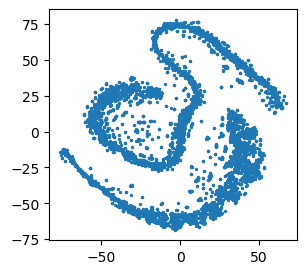

In [163]:
fig, ax = plt.subplots(figsize=(3.2,3))
ax.scatter(tsne.iloc[:,0], tsne.iloc[:,1], s=2)

In [166]:
n_cells = []

for i in new_mts_50:
    n_cells.append(len(new_mts_50[i]))
alive_cells = np.array(list(new_mts_50.keys()))[np.array(n_cells)!=0]
new_tsne = pd.DataFrame(columns=[0,1])
disturb = np.array(tsne.max()-tsne.min())/50
for cell in alive_cells:
    tsne_loc = tsne.loc[cell].to_numpy()
    for ind, i in enumerate(new_mts_50[cell]):
        new_tsne.loc[f'{cell}_{ind}'] = tsne_loc + np.random.normal(loc=tsne_loc, scale=disturb)

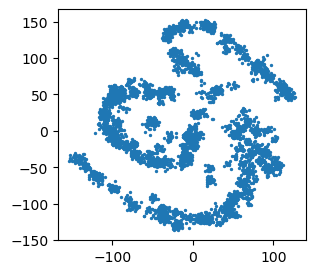

In [167]:
fig, ax = plt.subplots(figsize=(3.2,3))
ax.scatter(new_tsne.iloc[:,0], new_tsne.iloc[:,1], s=2)

In [180]:
n_cells = []

for i in new_mts_300:
    n_cells.append(len(new_mts_300[i]))
alive_cells = np.array(list(new_mts_300.keys()))[np.array(n_cells)!=0]
new_tsne = pd.DataFrame(columns=[0,1])
disturb = np.array(tsne.max()-tsne.min())/20
for cell in alive_cells:
    tsne_loc = tsne.loc[cell].to_numpy()
    for ind, i in enumerate(new_mts_300[cell]):
        new_tsne.loc[f'{cell}_{ind}'] = tsne_loc + np.random.normal(loc=tsne_loc, scale=disturb)

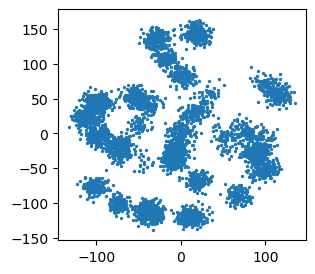

In [181]:
fig, ax = plt.subplots(figsize=(3.2,3))
ax.scatter(new_tsne.iloc[:,0], new_tsne.iloc[:,1], s=2)

In [176]:
n_cells = []

for i in new_mts_800:
    n_cells.append(len(new_mts_800[i]))
alive_cells = np.array(list(new_mts_800.keys()))[np.array(n_cells)!=0]
new_tsne = pd.DataFrame(columns=[0,1])
disturb = np.array(tsne.max()-tsne.min())/10
for cell in alive_cells:
    tsne_loc = tsne.loc[cell].to_numpy()
    for ind, i in enumerate(new_mts_800[cell]):
        new_tsne.loc[f'{cell}_{ind}'] = tsne_loc + np.random.normal(loc=tsne_loc, scale=disturb)
    
    

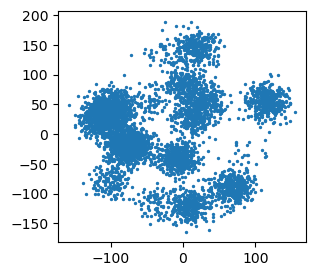

In [177]:
fig, ax = plt.subplots(figsize=(3.2,3))
ax.scatter(new_tsne.iloc[:,0], new_tsne.iloc[:,1], s=2)

In [194]:
def tsne_regenerate(tsne, mts_rs, distrub_scale=50):
    n_cells = []
    for i in mts_rs:
        n_cells.append(len(mts_rs[i]))
    living_cells = np.array(list(mts_rs.keys()))[np.array(n_cells)!=0]
    new_tsne = pd.DataFrame(columns=[0,1])
    disturb = np.array(tsne.max()-tsne.min())/distrub_scale
    for cell in living_cells:
        tsne_loc = tsne.loc[cell].to_numpy()
        for ind, i in enumerate(mts_rs[cell]):
            new_tsne.loc[f'{cell}_{ind}'] = tsne_loc + np.random.normal(loc=tsne_loc, scale=disturb)
    return new_tsne

Text(0.5, 1.0, '800_Gen')

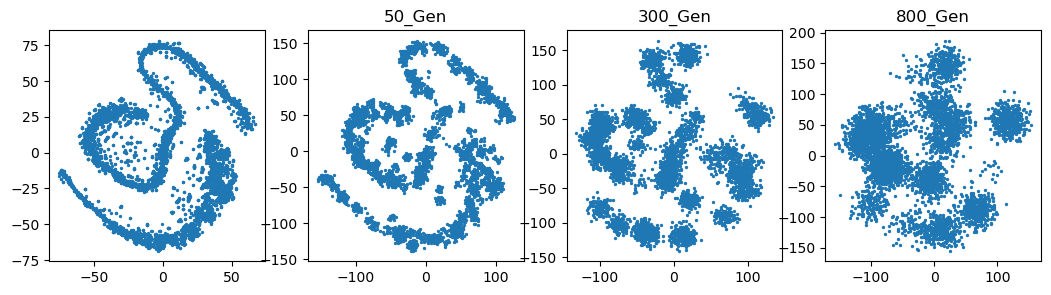

In [182]:
fig, ax = plt.subplots(1, 4, figsize=(3.2*4,3))
ax[0].scatter(tsne.iloc[:,0], tsne.iloc[:,1], s=2)

n_cells = []
for i in new_mts_50:
    n_cells.append(len(new_mts_50[i]))
alive_cells = np.array(list(new_mts_50.keys()))[np.array(n_cells)!=0]
new_tsne = pd.DataFrame(columns=[0,1])
disturb = np.array(tsne.max()-tsne.min())/50
for cell in alive_cells:
    tsne_loc = tsne.loc[cell].to_numpy()
    for ind, i in enumerate(new_mts_50[cell]):
        new_tsne.loc[f'{cell}_{ind}'] = tsne_loc + np.random.normal(loc=tsne_loc, scale=disturb)
ax[1].scatter(new_tsne.iloc[:,0], new_tsne.iloc[:,1], s=2)
ax[1].set_title('50_Gen')

n_cells = []
for i in new_mts_300:
    n_cells.append(len(new_mts_300[i]))
alive_cells = np.array(list(new_mts_300.keys()))[np.array(n_cells)!=0]
new_tsne = pd.DataFrame(columns=[0,1])
disturb = np.array(tsne.max()-tsne.min())/20
for cell in alive_cells:
    tsne_loc = tsne.loc[cell].to_numpy()
    for ind, i in enumerate(new_mts_300[cell]):
        new_tsne.loc[f'{cell}_{ind}'] = tsne_loc + np.random.normal(loc=tsne_loc, scale=disturb)
ax[2].scatter(new_tsne.iloc[:,0], new_tsne.iloc[:,1], s=2)
ax[2].set_title('300_Gen')    

n_cells = []
for i in new_mts_800:
    n_cells.append(len(new_mts_800[i]))
alive_cells = np.array(list(new_mts_800.keys()))[np.array(n_cells)!=0]
new_tsne = pd.DataFrame(columns=[0,1])
disturb = np.array(tsne.max()-tsne.min())/10
for cell in alive_cells:
    tsne_loc = tsne.loc[cell].to_numpy()
    for ind, i in enumerate(new_mts_800[cell]):
        new_tsne.loc[f'{cell}_{ind}'] = tsne_loc + np.random.normal(loc=tsne_loc, scale=disturb)
ax[3].scatter(new_tsne.iloc[:,0], new_tsne.iloc[:,1], s=2)
ax[3].set_title('800_Gen')  
    

In [185]:
def rs_cvt(mts_rs):
    mts_new = dict()
    n_cells = []
    for i in mts_rs:
        n_cells.append(len(mts_rs[i]))
    living_cells = np.array(list(mts_rs.keys()))[np.array(n_cells)!=0]
    for cell in living_cells:
        for cnt, c in enumerate(mts_rs[cell]):
            mts_new[f'{cell}_{cnt}'] = c
    return mts_new

In [186]:
mts_cvt = rs_cvt(new_mts_50)